Link Colab: https://colab.research.google.com/drive/1ei9XahXJvL1yOY7TNWf20obh0qrOCOSR?usp=sharing

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 792.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [ ]:
#Collegare Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importare roboflow e scaricare il dataset
from roboflow import Roboflow
rf = Roboflow(api_key="IwbjvxFzcbBgxgAJv6M2")
project = rf.workspace("aslvsbsl").project("aslvbsl")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ASLvBSL-2 in folder:: 100%|██████████| 5909/5909 [00:02<00:00, 2209.29it/s]


In [ ]:
import os

# Impostare il percorso dei dati scaricati
dataset_path = dataset.location  # Questo imposta automaticamente il percorso del dataset scaricato

# Impostare i percorsi in base alla struttura stampata
train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

# Verifica delle directory
assert os.path.exists(train_dir), f"Directory {train_dir} non trovata."
assert os.path.exists(valid_dir), f"Directory {valid_dir} non trovata."
assert os.path.exists(test_dir), f"Directory {test_dir} non trovata."

print("Tutte le directory esistono.")

Tutte le directory esistono.


Found 3840 images belonging to 48 classes.
Found 672 images belonging to 48 classes.
Found 1248 images belonging to 48 classes.
Epoch 1/60
120/120 [==============================] - 93s 704ms/step - loss: 52.2886 - accuracy: 0.0169 - val_loss: 23.9393 - val_accuracy: 0.0208 - lr: 1.0000e-04
Epoch 2/60
120/120 [==============================] - 92s 767ms/step - loss: 13.4719 - accuracy: 0.0206 - val_loss: 7.2012 - val_accuracy: 0.0208 - lr: 1.0000e-04
Epoch 3/60
120/120 [==============================] - 84s 701ms/step - loss: 5.2834 - accuracy: 0.0294 - val_loss: 4.0993 - val_accuracy: 0.0640 - lr: 1.0000e-04
Epoch 4/60
120/120 [==============================] - 85s 712ms/step - loss: 3.7592 - accuracy: 0.0557 - val_loss: 3.3661 - val_accuracy: 0.0893 - lr: 1.0000e-04
Epoch 5/60
120/120 [==============================] - 84s 698ms/step - loss: 3.4105 - accuracy: 0.0849 - val_loss: 2.9495 - val_accuracy: 0.1890 - lr: 1.0000e-04
Epoch 6/60
120/120 [==============================] - 90s 7

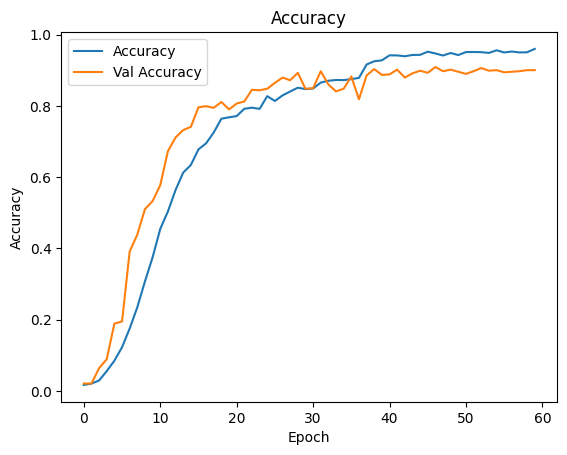

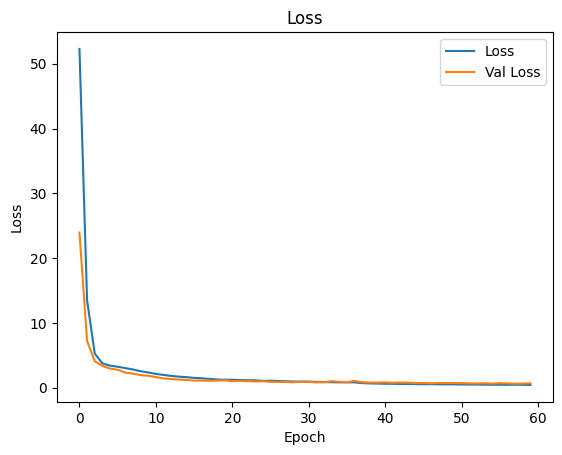

39/39 [==============================] - 12s 312ms/step - loss: 0.6390 - accuracy: 0.8942
Test accuracy: 0.8942307829856873


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt

# Caricamento del dataset con data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Creazione del modello AlexNet
model = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(48, activation='softmax')
])

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Aggiungere EarlyStopping e ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Allena il modello
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, reduce_lr]
)

# Visualizzazione dell'accuratezza di training e validation
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizzazione della perdita di training e validation
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Valutazione del modello sul set di test
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


Found 3840 images belonging to 48 classes.
Found 672 images belonging to 48 classes.
Found 1248 images belonging to 48 classes.
Epoch 1/80
120/120 [==============================] - 107s 801ms/step - loss: 52.9089 - accuracy: 0.0167 - val_loss: 24.6572 - val_accuracy: 0.0342 - lr: 1.0000e-04
Epoch 2/80
120/120 [==============================] - 92s 765ms/step - loss: 14.0615 - accuracy: 0.0247 - val_loss: 7.6630 - val_accuracy: 0.0417 - lr: 1.0000e-04
Epoch 3/80
120/120 [==============================] - 89s 740ms/step - loss: 5.6309 - accuracy: 0.0594 - val_loss: 4.1981 - val_accuracy: 0.0744 - lr: 1.0000e-04
Epoch 4/80
120/120 [==============================] - 90s 753ms/step - loss: 4.0365 - accuracy: 0.0737 - val_loss: 3.4836 - val_accuracy: 0.1458 - lr: 1.0000e-04
Epoch 5/80
120/120 [==============================] - 90s 749ms/step - loss: 3.6013 - accuracy: 0.1198 - val_loss: 3.0379 - val_accuracy: 0.2024 - lr: 1.0000e-04
Epoch 6/80
120/120 [==============================] - 91s 

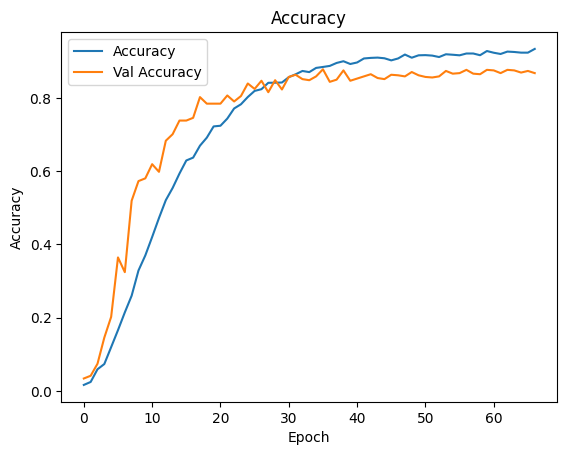

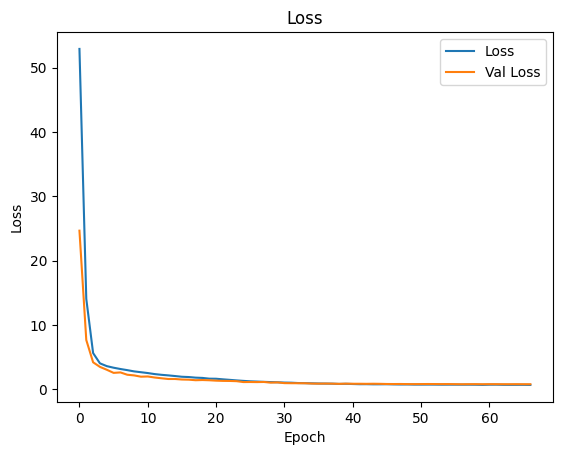

39/39 [==============================] - 11s 292ms/step - loss: 0.7869 - accuracy: 0.8846
Test accuracy: 0.8846153616905212


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt

# Caricamento del dataset con data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Nuovo parametro
    channel_shift_range=0.2  # Nuovo parametro
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Creazione del modello AlexNet
model = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),  # Aumentato il dropout
    Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),  # Aumentato il dropout
    Dense(48, activation='softmax')
])

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Aggiungere EarlyStopping, ReduceLROnPlateau e LearningRateScheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Allena il modello
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=80,  # Aumentato il numero di epoche
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

# Visualizzazione dell'accuratezza di training e validation
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizzazione della perdita di training e validation
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Valutazione del modello sul set di test
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
